In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from operator import itemgetter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

In [2]:
def select_features(X_train, y_train, X_test, n_features_to_remove=5):
    columns = list(X_train.columns)
    estimator = RandomForestRegressor().fit(X_train, y_train)
    feature_importance = [(i, score) for i, score in enumerate(estimator.feature_importances_)]
    feature_importance.sort(key=itemgetter(1))
    for col in feature_importance[:n_features_to_remove]:
        del columns[col[0]]
    X_train = X_train[columns]
    X_test = X_test[columns]
    return X_train, X_test

In [3]:
def log_transformation(y):
    return np.log1p(y)

In [4]:
def prepare_data_and_fit_model(data, model, scale_data=False, feature_selection=False, n_features_to_remove=5, log_transform=False):
    X = data.copy()
    y = X.pop('SalePrice')
    
    if log_transform:
        y = log_transformation(y)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, shuffle=True)
    
    if feature_selection:
        X_train, X_test = select_features(X_train, y_train, X_test, n_features_to_remove)
        
    if scale_data:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    if model == 'RF':
        model = RandomForestRegressor().fit(X_train, y_train)
        
    elif model == 'GB':
        model = GradientBoostingRegressor().fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    correlation_matrix = pd.DataFrame(X).corr()
    
    result = {'X': X,
             'y': y,
             'x_train': X_train,
             'x_test': X_test, 
             'y_train': y_train,
             'y_test': y_test,
             'model': model,
             'predictions': predictions,
             'mse': mse,
             'mape': mape, 
             'r2': r2,
             'correlation_matrix': correlation_matrix
            }
    
    return result

## Reading the data and taking a look inside

In [5]:
train_data, test_data = pd.read_csv('regression_train.csv'), pd.read_csv('regression_test.csv')
data = pd.concat([test_data, train_data], ignore_index=True)
data.sample(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1249,70,RM,60.0,3600,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2006,WD,Normal,114504
458,20,RL,NaN,9156,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2009,WD,Normal,185750
852,60,FV,100.0,12552,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,GdWo,NaN,0,5,2010,WD,Normal,254900
1429,20,RL,88.0,13125,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,GdPrv,NaN,0,1,2006,WD,Normal,155000
473,20,RL,60.0,8072,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,138000
558,60,RL,65.0,8158,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,224900
1025,20,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,1,2008,New,Partial,372402
399,50,RL,NaN,7015,Pave,NaN,IR1,Bnk,AllPub,Corner,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,110000
1208,70,RL,51.0,9842,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,189000
899,20,RL,NaN,9503,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdWo,NaN,0,6,2007,WD,Normal,144000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1459 non-null   object 
 2   LotFrontage    1200 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1459 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuil

In [7]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Removing and filling Nan-values

In [8]:
data.isna().sum()

MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1368
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea 

As we can see above there are some columns that mostly contain Nan-values, for example Alley, Fireplace and Fence. In the next step we will remove them and fill those that only have some Nan-values with the most common value for that column. 

#### Removing columns with more than 100 Nan-values

In [9]:
columns = data.columns
nan_columns = []
for i, val in enumerate(data.isna().sum()):
    if val > 100:
        nan_columns.append(columns[i])
data = data.drop(nan_columns, axis=1)

#### Filling the remaning Nan-values with the most common value for that column

In [10]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
result = imputer.fit_transform(data)
new_data = pd.DataFrame(result, columns=data.columns)

new_data = new_data.astype(data.dtypes)
new_data.isna().sum().sum()

0

Now we have no Nan-values left in our data.

## Encoding string variables

In [11]:
from category_encoders.binary import BinaryEncoder
encoder = BinaryEncoder(return_df=True)
data = encoder.fit_transform(new_data)

C:\Users\sarak\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


All the categorical columns were encoded, and now we have 177 columns insted of 74. 

## Distribution plot

In [12]:
X = data.copy()
y = X.pop('SalePrice')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, shuffle=True)

Text(0, 0.5, 'Amount')

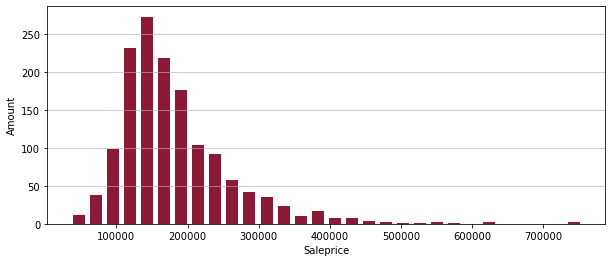

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(y, bins='scott', color='#800020',
                            alpha=0.9, rwidth=0.7)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Saleprice')
plt.ylabel('Amount')

#### Distribution after log transform

Text(0, 0.5, 'Amount')

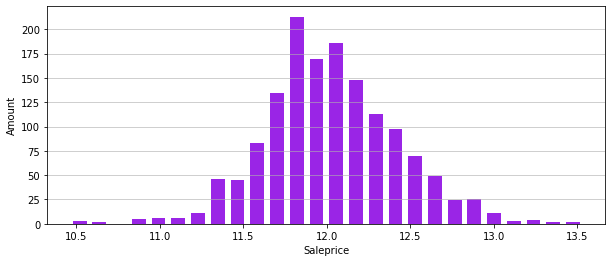

In [14]:
y = log_transformation(y)
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(y, bins='scott', color='#8f0de4',
                            alpha=0.9, rwidth=0.7)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Saleprice')
plt.ylabel('Amount')

## Correlations

#### With all features

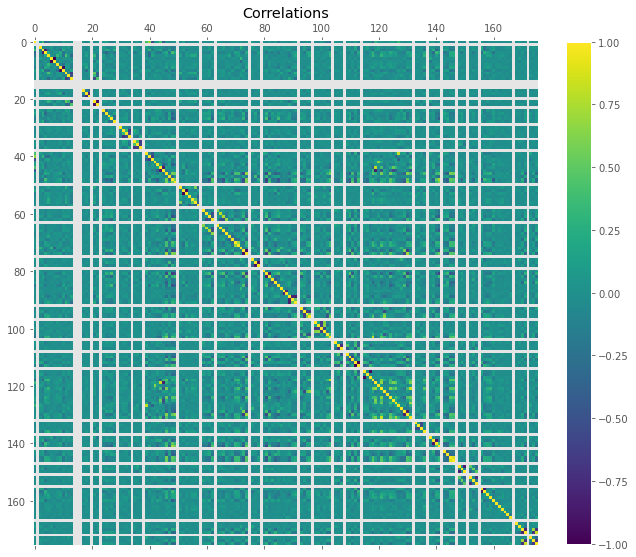

In [15]:
with plt.style.context('ggplot'):
    matfig = plt.figure(figsize=(10,10))
    plt.matshow(X_train.corr(), fignum=matfig.number)
    plt.grid(False)
    plt.title('Correlations')
    plt.colorbar(fraction = 0.045)

#### Removing 5 features

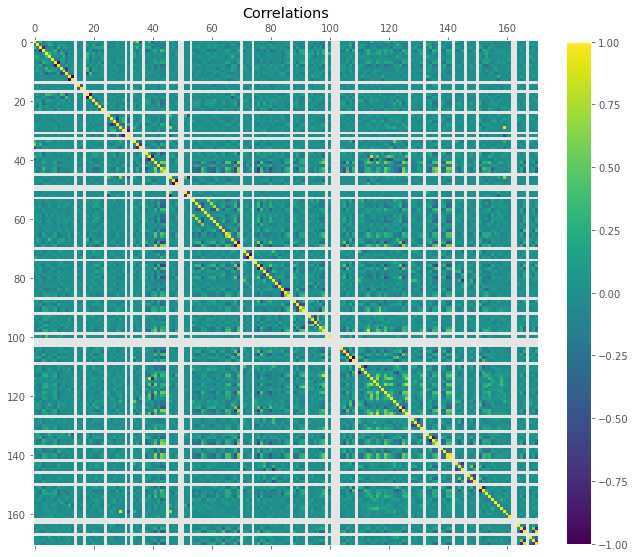

In [16]:
X_train, _ = select_features(X_test, y_test, X_train)
with plt.style.context('ggplot'):
    matfig = plt.figure(figsize=(10,10))
    plt.matshow(X_train.corr(), fignum=matfig.number)
    plt.grid(False)
    plt.title('Correlations')
    plt.colorbar(fraction = 0.045)

## Random Forest

In [17]:
result = prepare_data_and_fit_model(data, 'RF')
print(f'R2: {result["r2"]}, MSE: {result["mse"]}, MAPE: {result["mape"]}')

R2: 0.868735176657786, MSE: 985817227.9402723, MAPE: 0.09720931676373774


#### With data scaling

In [18]:
result = prepare_data_and_fit_model(data, 'RF', scale_data=True)
print(f'R2: {result["r2"]}, MSE: {result["mse"]}, MAPE: {result["mape"]}')

R2: 0.8613761192750985, MSE: 1041084780.6976552, MAPE: 0.09713854263055184


#### With feature selection

In [19]:
result = prepare_data_and_fit_model(data, 'RF', feature_selection=True)
print(f'R2: {result["r2"]}, MSE: {result["mse"]}, MAPE: {result["mape"]}')

R2: 0.8705114556734204, MSE: 972477123.4807861, MAPE: 0.09594421149138505


#### With log tranform

In [20]:
result = prepare_data_and_fit_model(data, 'RF', log_transform=True)
print(f'R2: {result["r2"]}, MSE: {result["mse"]}, MAPE: {result["mape"]}')

R2: 0.8894346908808788, MSE: 0.01944585658982881, MAPE: 0.007879313724995519


#### With data scaling, feature selection and log transform

In [21]:
result = prepare_data_and_fit_model(data, 'RF', scale_data=True, log_transform=True, feature_selection=True)
print(f'R2: {result["r2"]}, MSE: {result["mse"]}, MAPE: {result["mape"]}')

R2: 0.8852565056791587, MSE: 0.02018070182189756, MAPE: 0.008057950008953933


## Gradient Booster

In [22]:
result = prepare_data_and_fit_model(data, 'GB')
print(f'R2: {result["r2"]}, MSE: {result["mse"]}, MAPE: {result["mape"]}')

R2: 0.8979323509266101, MSE: 766542355.4457406, MAPE: 0.09165068304402743


#### With data scaling

In [23]:
result = prepare_data_and_fit_model(data, 'GB', scale_data=True)
print(f'R2: {result["r2"]}, MSE: {result["mse"]}, MAPE: {result["mape"]}')

R2: 0.8984989749193961, MSE: 762286929.81357, MAPE: 0.09186950601887643


#### Wtih feature selection

In [24]:
result = prepare_data_and_fit_model(data, 'GB', feature_selection=True)
print(f'R2: {result["r2"]}, MSE: {result["mse"]}, MAPE: {result["mape"]}')

R2: 0.9085739520803495, MSE: 686622438.7223109, MAPE: 0.09106202834645943


#### With log transform 

In [25]:
result = prepare_data_and_fit_model(data, 'GB', log_transform=True)
print(f'R2: {result["r2"]}, MSE: {result["mse"]}, MAPE: {result["mape"]}')

R2: 0.9138636269990645, MSE: 0.015149377050441566, MAPE: 0.007090129128636315


#### With data scaling, feature selection and log transform

In [26]:
result = prepare_data_and_fit_model(data, 'GB', scale_data=True, log_transform=True, feature_selection=True)
print(f'R2: {result["r2"]}, MSE: {result["mse"]}, MAPE: {result["mape"]}')

R2: 0.914036580996378, MSE: 0.015118958480139647, MAPE: 0.007073150480263465
